# COVID-19 Chest X-Ray Classification using Deep Learning with XAI

## HCAIM Combined Project
**Modules:** HC Deep Learning (HCDL) & Future of AI and Learning (FAI)

**Team Members:** Martin von Allesch, Dylan Byrne, Alejandro Sanchez Silva, Abdelrahman Shehata

**Date:** 

---

## 1. Setup and Imports

In [53]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
from pathlib import Path

# ML and evaluation imports
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Default visualization settings
plt.style.use('default')
sns.set_palette("coolwarm")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.15.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration Parameters

In [43]:
# Project configuration
DATA_DIR = 'COVID-19_Radiography_Dataset'
IMG_SIZE = (224, 224) # for Densenet121 compatibility
BATCH_SIZE = 64
NUM_CLASSES = 4
CLASS_NAMES = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
EPOCHS = 30
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# Create directories for saving results
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Set random seeds
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 2. Data Loading and Exploration

In [10]:
def explore_dataset(data_dir, class_names):
    """Explore dataset and calculate class distribution"""
    class_counts = {}
    
    print("Dataset Exploration\n")
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name, 'images')
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            print(f"{class_name:20s}: {count:,} images")
        else:
            print(f"{class_name:20s}: Directory not found")
            class_counts[class_name] = 0
    
    total_images = sum(class_counts.values())
    print(f"\nTotal images: {total_images:,}")
    
    # Calculate class weights for imbalanced data
    class_weights = {}
    for idx, class_name in enumerate(class_names):
        if class_counts[class_name] > 0:
            weight = total_images / (len(class_names) * class_counts[class_name])
            class_weights[idx] = weight
    
    return class_counts, class_weights

# Explore the dataset
class_counts, class_weights = explore_dataset(DATA_DIR, CLASS_NAMES)
print(f"\nClass weights: {class_weights}")

Dataset Exploration

✓ COVID               : 3,616 images
✓ Normal              : 10,192 images
✓ Viral Pneumonia     : 1,345 images
✓ Lung_Opacity        : 6,012 images

Total images: 21,165

Class weights: {0: 1.4632881637168142, 1: 0.5191571821036107, 2: 3.934014869888476, 3: 0.8801147704590818}


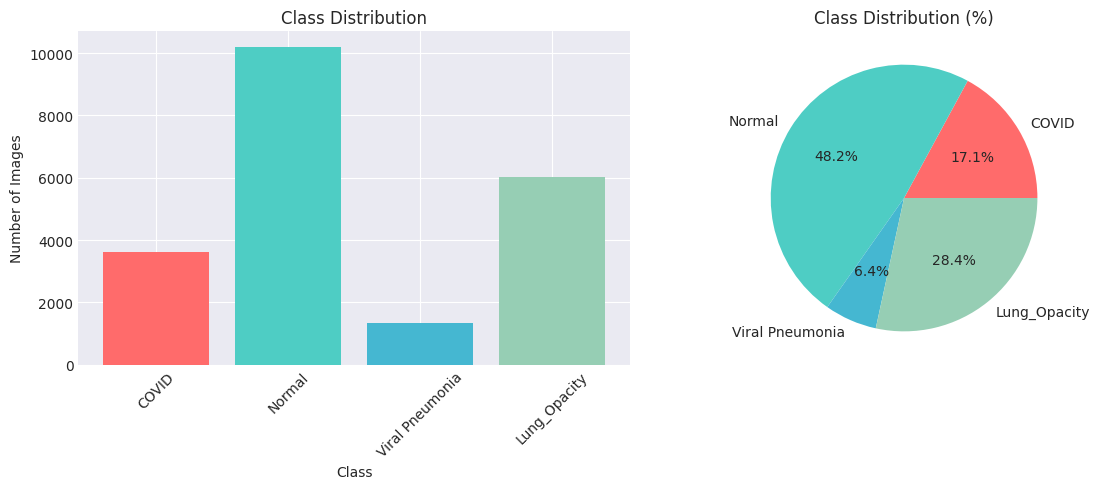

In [11]:
def visualize_class_distribution(class_counts):
    """Visualize class distribution"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    axes[0].bar(class_counts.keys(), class_counts.values(), color=colors)
    axes[0].set_title('Class Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Pie chart
    axes[1].pie(class_counts.values(), labels=class_counts.keys(), 
                autopct='%1.1f%%', colors=colors)
    axes[1].set_title('Class Distribution (%)')
    
    plt.tight_layout()
    plt.savefig('figures/class_distribution.png', dpi=150)
    plt.show()

visualize_class_distribution(class_counts)

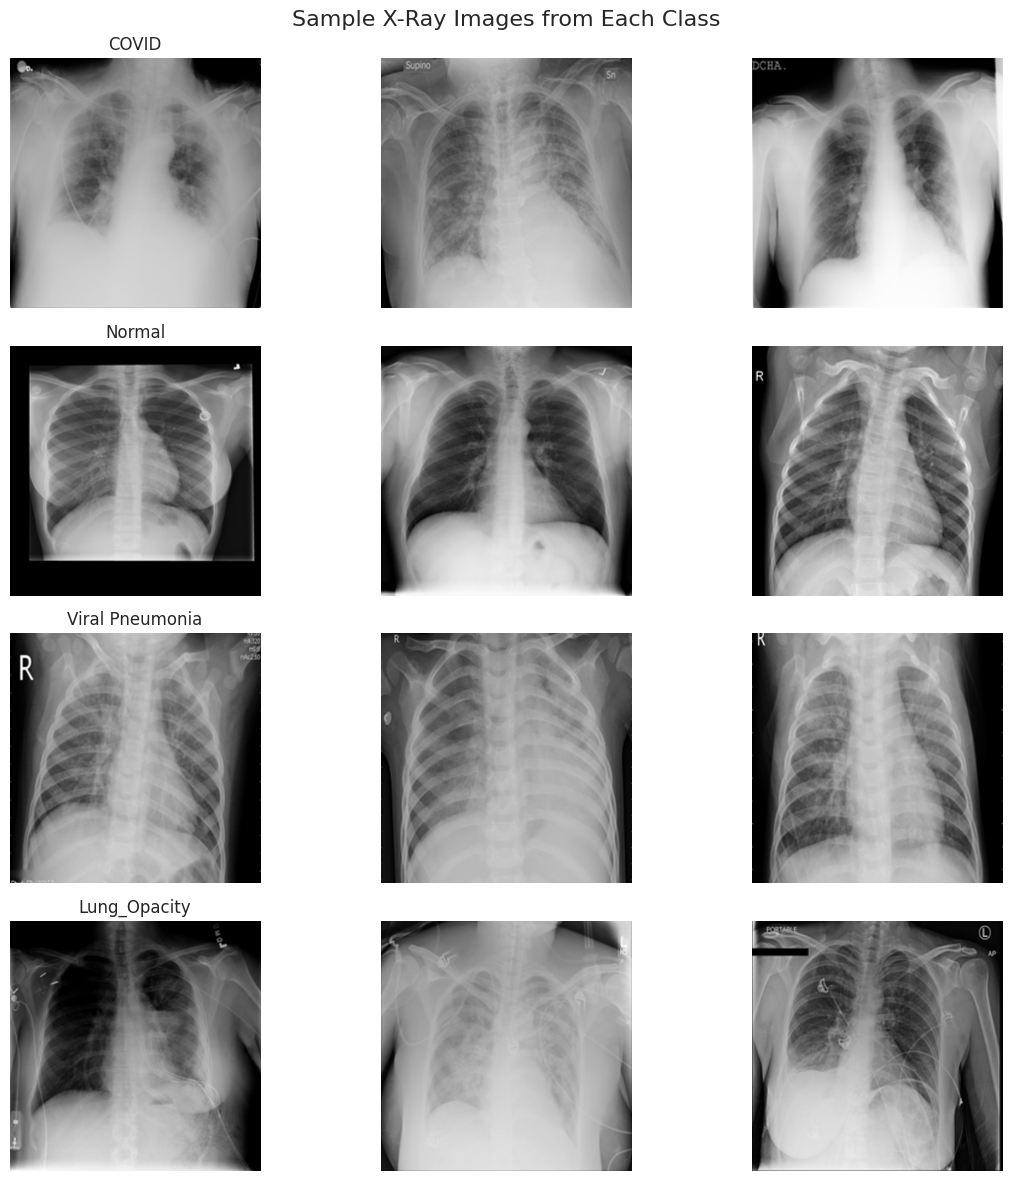

In [12]:
def visualize_sample_images(data_dir, class_names, num_samples=3):
    """Display sample images from each class"""
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(12, 12))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name, 'images')
        if os.path.exists(class_path):
            images = os.listdir(class_path)[:num_samples]
            
            for j, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(class_name)
    
    plt.suptitle('Sample X-Ray Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(DATA_DIR, CLASS_NAMES)

## 3. Data Preprocessing and Augmentation

### One-time preprocessing to split images into subfolders
Note: the split-folders library performs stratified splitting by default. It processes each class folder independently, splitting that class's images according to the given ratio, then combines them. The code creates a data_split/ folder with train/, val/, test/ subdirectories, each maintaining the class folder structure and stratified proportions.

In [26]:
'''
import splitfolders
import shutil

# Create a flat structure for splitfolders
FLAT_DIR = "COVID-19_Flat"
class_folders = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

if os.path.exists(FLAT_DIR):
    shutil.rmtree(FLAT_DIR)

for class_name in class_folders:
    src = os.path.join(DATA_DIR, class_name, "images")
    dst = os.path.join(FLAT_DIR, class_name)
    shutil.copytree(src, dst)
    print(f"{class_name}: {len(os.listdir(dst))} images")

if os.path.exists("data_split"):
    shutil.rmtree("data_split")

splitfolders.ratio(
    FLAT_DIR,
    output="data_split",
    seed=RANDOM_SEED,
    ratio=(0.7, 0.15, 0.15),
    move=False
)
'''

COVID: 3616 images
Lung_Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


### Data Generators 
with real-time augmentation for training (rotation, shifts, flips, zoom) to reduce overfitting and improve generalization. Validation and test sets receive only pixel normalization (rescaling to 0-1) to ensure consistent evaluation. Advantage of using ImageDataGenerator is memory efficiency (images are loaded batch-by-batch) and the possibility to apply real-time augmentation and normalization.

In [45]:
# Training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Validation and test data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    "data_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

val_gen = val_datagen.flow_from_directory(
    "data_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    "data_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")

Found 14814 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3179 images belonging to 4 classes.
Training samples: 14814
Validation samples: 3172
Test samples: 3179


## 4. Model Development

### 4.1 DenseNet121 Model with Transfer Learning (Black Box Complex)

Pretrained on ImageNet, learned features from 14M+ images, which makes it a good choice for transfer learning with limited medical data. Densenet is  widely used in radiology, e.g. CheXNet for chest X-rays. It is compatible with Grad-CAM, SHAP, and LIME for explainability.

In [28]:
def build_densenet121(num_classes, img_size, trainable_layers=10):

    # Load and configure DenseNet121 base model without classification head, using ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )
    base_model.trainable = False # Freeze layers initially

     # Build classification head with pooling → dense layers with regularization → output
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Unfreeze last n layers for fine-tuning on X-ray specific features
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    print(f"DenseNet121 built with {model.count_params():,} parameters")
    return model

# Build DenseNet121 model
densenet_model = build_densenet121(NUM_CLASSES, IMG_SIZE)

DenseNet121 built with 7,334,852 parameters


### 4.2 CNN Model (Black Box Simple)
For comparison, we implement a custom CNN. Its simpler structure makes it easier to understand learned features and shows value added by transfer learning vs training from scratch.

In [49]:
def build_cnn(num_classes, img_size):
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(*img_size, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    print(f"Simple CNN built with {model.count_params():,} parameters")
    return model

simple_cnn_model = build_cnn(NUM_CLASSES, IMG_SIZE)

Simple CNN built with 421,828 parameters


In [42]:
'''
def build_cnn(num_classes, img_size):
    
    model = Sequential([

        layers.Conv2D(32, (7, 7), activation='relu', input_shape=(*img_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    print(f"Simple CNN built with {model.count_params():,} parameters")
    return model

simple_cnn_model = build_cnn(NUM_CLASSES, IMG_SIZE)
'''

Simple CNN built with 10,370,500 parameters


## 5. Model Training

### Configuration 
of optimizer, loss function, and evaluation metrics (including precision/recall/AUC for imbalanced data). Callbacks: early stopping, checkpointing for saving the best model, and learning rate scheduling for adaptive optimization.

In [29]:
def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    return model

def get_callbacks(model_name):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'models/best_{model_name}.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        CSVLogger(f'results/{model_name}_training.csv')
    ]
    return callbacks

### 5.1 Train DenseNet121

In [30]:
# Compile DenseNet121
densenet_model = compile_model(densenet_model, LEARNING_RATE)

# Train DenseNet121
print("Training DenseNet121...")
densenet_history = densenet_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=get_callbacks('densenet121'),
    class_weight=class_weights,
    verbose=1
)
print("DenseNet121 training completed!")

Training DenseNet121...
Epoch 1/30
463/463 [==============================] - 204s 428ms/step - loss: 1.2227 - accuracy: 0.6980 - precision: 0.7246 - recall: 0.6652 - auc: 0.8850 - val_loss: 0.6479 - val_accuracy: 0.7724 - val_precision: 0.7863 - val_recall: 0.7563 - val_auc: 0.9323 - lr: 0.0010
Epoch 2/30
463/463 [==============================] - 198s 428ms/step - loss: 0.8097 - accuracy: 0.7506 - precision: 0.7658 - recall: 0.7340 - auc: 0.9228 - val_loss: 0.6619 - val_accuracy: 0.7547 - val_precision: 0.7656 - val_recall: 0.7434 - val_auc: 0.9357 - lr: 0.0010
Epoch 3/30
463/463 [==============================] - 199s 429ms/step - loss: 0.7296 - accuracy: 0.7669 - precision: 0.7801 - recall: 0.7508 - auc: 0.9337 - val_loss: 0.5646 - val_accuracy: 0.7963 - val_precision: 0.8038 - val_recall: 0.7828 - val_auc: 0.9492 - lr: 0.0010
Epoch 4/30
463/463 [==============================] - 188s 405ms/step - loss: 0.6678 - accuracy: 0.7814 - precision: 0.7937 - recall: 0.7653 - auc: 0.9423 - 

### 5.2 Train CNN

In [50]:
# Compile Simple CNN
simple_cnn_model = compile_model(simple_cnn_model, LEARNING_RATE)

# Train Simple CNN
print("Training CNN...")
cnn_history = simple_cnn_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=get_callbacks('simple_cnn'),
    class_weight=class_weights,
    verbose=1
)
print("CNN training completed!")

Training CNN...
Epoch 1/30


2025-11-26 19:35:46.945097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSimple_CNN/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


232/232 [==============================] - 195s 833ms/step - loss: 1.6513 - accuracy: 0.4804 - precision: 0.4817 - recall: 0.4754 - auc: 0.6962 - val_loss: 1.3409 - val_accuracy: 0.4817 - val_precision: 0.4832 - val_recall: 0.4817 - val_auc: 0.7420 - lr: 0.0010
Epoch 2/30
232/232 [==============================] - 190s 819ms/step - loss: 1.5029 - accuracy: 0.4816 - precision: 0.4832 - recall: 0.4797 - auc: 0.7408 - val_loss: 1.1771 - val_accuracy: 0.4817 - val_precision: 0.5075 - val_recall: 0.4770 - val_auc: 0.7828 - lr: 0.0010
Epoch 3/30
232/232 [==============================] - 192s 824ms/step - loss: 1.3633 - accuracy: 0.4826 - precision: 0.5059 - recall: 0.4746 - auc: 0.7823 - val_loss: 1.2451 - val_accuracy: 0.4817 - val_precision: 0.5038 - val_recall: 0.4808 - val_auc: 0.8024 - lr: 0.0010
Epoch 4/30
232/232 [==============================] - 185s 799ms/step - loss: 1.2698 - accuracy: 0.4970 - precision: 0.5367 - recall: 0.4757 - auc: 0.8090 - val_loss: 0.9811 - val_accuracy: 0.

### 5.3 Visualize Training History

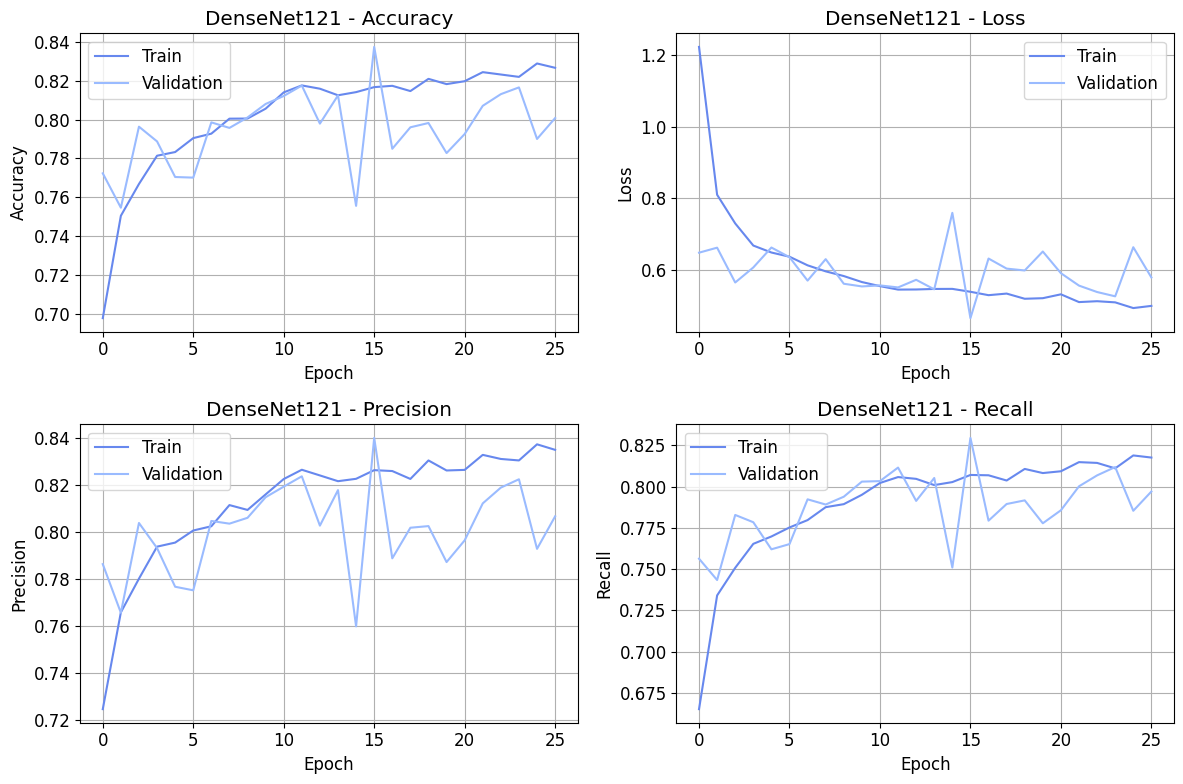

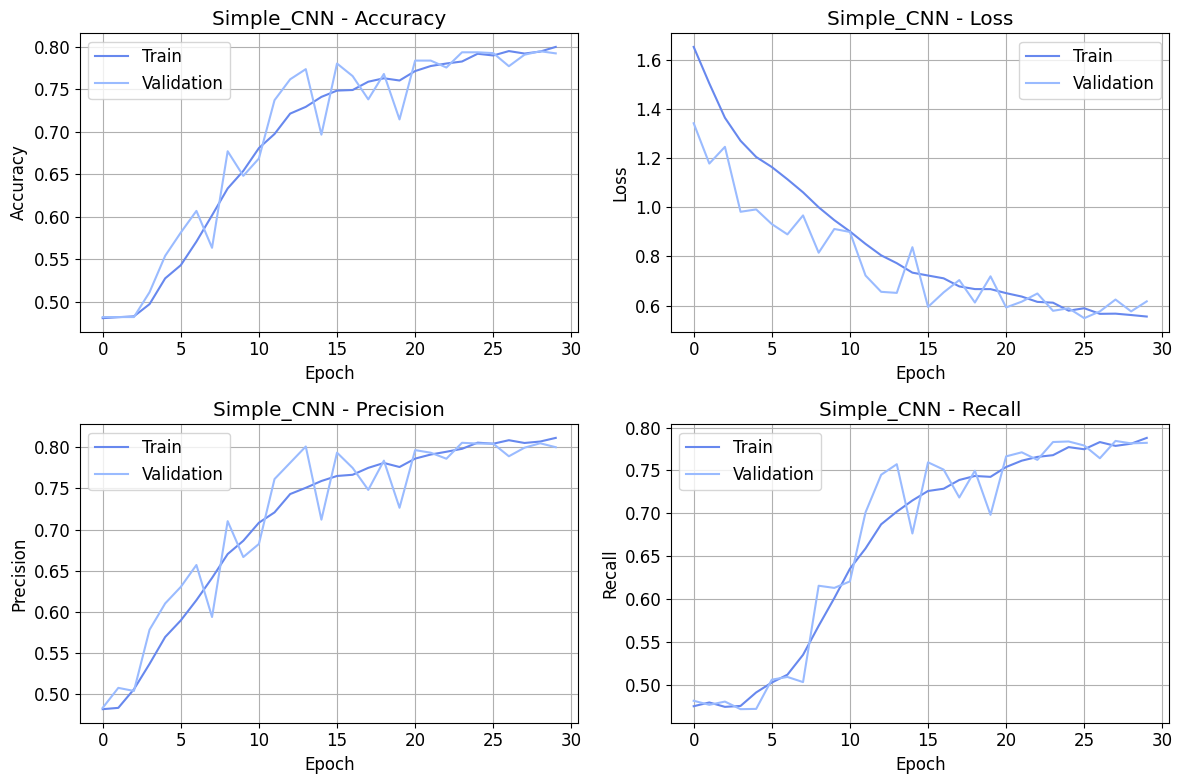

In [61]:
def plot_training_history(history, model_name):
    """Plot training history for a model"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title(f'{model_name} - Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title(f'{model_name} - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title(f'{model_name} - Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title(f'{model_name} - Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/{model_name}_training_history.png', dpi=150)
    plt.show()

# Plot training histories
plot_training_history(densenet_history, 'DenseNet121')
plot_training_history(cnn_history, 'Simple_CNN')